Using device: cuda
PyTorch version: 2.7.0+cu128
Loading datasets...
Training set: (1296675, 23)
Test set: (555719, 23)
Preprocessing training data...
Features shape: (1296675, 22)
Target shape: (1296675,)
Feature columns: ['amt', 'gender', 'city_pop', 'hour', 'day_of_week', 'month', 'age', 'state_encoded', 'cat_entertainment', 'cat_food_dining', 'cat_gas_transport', 'cat_grocery_net', 'cat_grocery_pos', 'cat_health_fitness', 'cat_home', 'cat_kids_pets', 'cat_misc_net', 'cat_misc_pos', 'cat_personal_care', 'cat_shopping_net', 'cat_shopping_pos', 'cat_travel']

Preprocessing test data...
Test features shape: (555719, 22)
Test target shape: (555719,)
Training set: 1,102,173 samples
Validation set: 194,502 samples
Test set: 555,719 samples

Fraud rate - Train: 0.58%
Fraud rate - Val: 0.58%
Fraud rate - Test: 0.39%
Class distribution - Non-Fraud: 1,095,793.0, Fraud: 6,380.0
Class weight ratio: 1:172
Batch size: 1024
Training batches: 1077
Validation batches: 190
Input features: 22

Model Ar

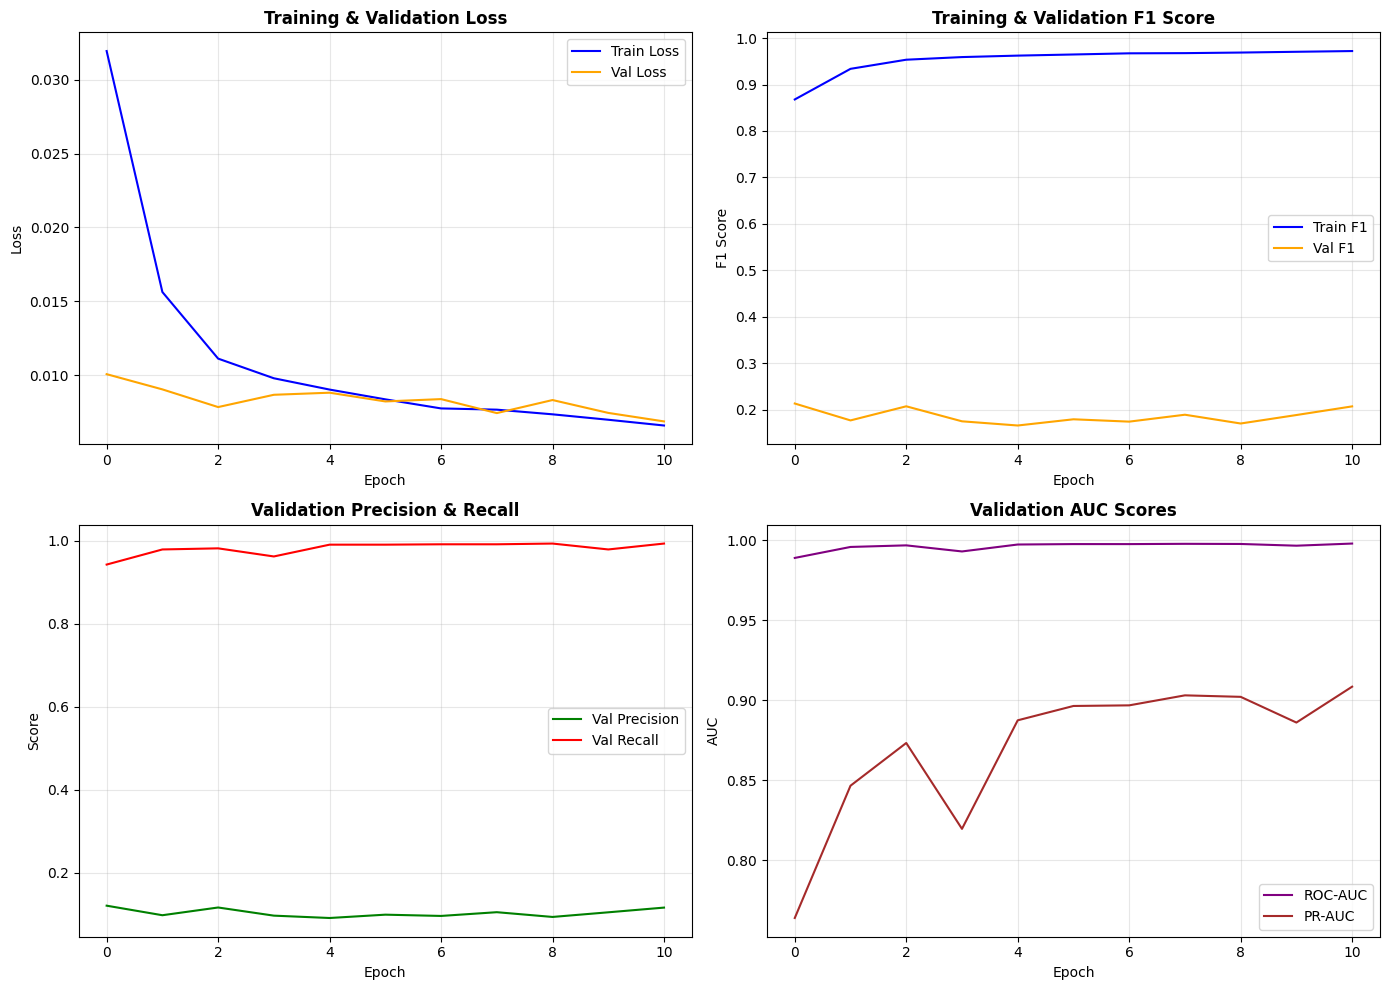

✓ Saved: training_curves.png
✓ Saved: nn_model.pth
✓ Saved: encoders.pkl
✓ Saved: scaler.pkl
✓ Saved: training_history.pkl
✓ Saved: model_config.json
VALIDATION RESULTS (Best Model)
Loss:      0.0069
F1 Score:  0.2072
Precision: 0.1157
Recall:    0.9929
ROC-AUC:   0.9978
PR-AUC:    0.9084

NEURAL NETWORK TRAINING COMPLETE!

Model saved to: models/non_pca_primary/
- nn_model.pth (model weights)
- encoders.pkl (categorical encoders)
- scaler.pkl (feature scaler)
- model_config.json (architecture config)
- training_history.pkl (training metrics)

Next steps:
1. Run 03_non_pca_primary_inference.ipynb for model inference
2. Run 04_non_pca_primary_evaluation.ipynb for detailed evaluation



In [1]:
# =============================================================================
# NOTEBOOK 02: NEURAL NETWORK TRAINING - NON-PCA PRIMARY (SPARKOV)
# =============================================================================
# Author: Muhammad Ali Tahir
# MS Data Science Program, Superior University Lahore
# Dataset: Sparkov Credit Card Transactions (Interpretable Features)
# =============================================================================

# %% [markdown]
# # 2. Neural Network Training - Sparkov Fraud Detection
#
# This notebook trains a deep neural network on the Sparkov dataset with:
# - Proper feature encoding (categorical → numeric)
# - Class imbalance handling (Focal Loss + Class Weights)
# - Early stopping and model checkpointing

# %% [markdown]
# ## 2.1 Import Libraries

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score, f1_score)

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# %% [markdown]
# ## 2.2 Load Dataset

# %%
# Load training and test data
print("Loading datasets...")
train_df = pd.read_csv('../../data/non_pca_primary/fraudTrain.csv')
test_df = pd.read_csv('../../data/non_pca_primary/fraudTest.csv')

print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

# %% [markdown]
# ## 2.3 Feature Engineering & Preprocessing

# %%
def preprocess_data(df, is_training=True, encoders=None, scaler=None):
    """
    Preprocess the dataframe:
    1. Extract temporal features
    2. Calculate age
    3. Encode categorical variables
    4. Scale numeric features
    """
    df = df.copy()

    # ========== 1. TEMPORAL FEATURES ==========
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month

    # ========== 2. AGE CALCULATION ==========
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

    # ========== 3. DROP UNNECESSARY COLUMNS ==========
    drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant',
                 'first', 'last', 'street', 'city', 'zip', 'lat', 'long',
                 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # ========== 4. ENCODE CATEGORICAL FEATURES ==========
    if encoders is None:
        encoders = {}

    # Gender: Binary encoding
    if is_training:
        encoders['gender'] = {'M': 1, 'F': 0}
    df['gender'] = df['gender'].map(encoders['gender']).astype(int)

    # State: Target Encoding (mean fraud rate per state) - DO THIS BEFORE DROPPING is_fraud
    if is_training:
        state_fraud_rate = df.groupby('state')['is_fraud'].mean().to_dict()
        encoders['state'] = state_fraud_rate
        encoders['state_default'] = df['is_fraud'].mean()

    df['state_encoded'] = df['state'].map(encoders['state']).fillna(encoders['state_default']).astype(float)
    df = df.drop(columns=['state'])

    # Category: One-Hot Encoding
    if is_training:
        category_dummies = pd.get_dummies(df['category'], prefix='cat')
        encoders['category_cols'] = category_dummies.columns.tolist()
    else:
        category_dummies = pd.get_dummies(df['category'], prefix='cat')
        # Ensure all columns exist (for test set)
        for col in encoders['category_cols']:
            if col not in category_dummies.columns:
                category_dummies[col] = 0
        # Remove extra columns not in training
        category_dummies = category_dummies[[col for col in encoders['category_cols'] if col in category_dummies.columns]]

    # Ensure correct order and all columns present
    for col in encoders.get('category_cols', []):
        if col not in category_dummies.columns:
            category_dummies[col] = 0
    category_dummies = category_dummies[encoders['category_cols']]

    df = pd.concat([df.reset_index(drop=True), category_dummies.reset_index(drop=True)], axis=1)
    df = df.drop(columns=['category'])

    # ========== 5. SEPARATE FEATURES AND TARGET ==========
    y = df['is_fraud'].values.astype(np.float32)
    X = df.drop(columns=['is_fraud'])

    # ========== 6. ENSURE ALL COLUMNS ARE NUMERIC ==========
    # Check for any remaining object columns
    object_cols = X.select_dtypes(include=['object']).columns.tolist()
    if object_cols:
        print(f"WARNING: Dropping remaining object columns: {object_cols}")
        X = X.drop(columns=object_cols)

    # Convert all to float32
    X = X.astype(np.float32)

    # ========== 7. SCALE NUMERIC FEATURES ==========
    numeric_cols = ['amt', 'city_pop', 'age', 'hour', 'day_of_week', 'month', 'state_encoded']
    numeric_cols = [col for col in numeric_cols if col in X.columns]

    if is_training:
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    # Final conversion to float32
    X = X.astype(np.float32)

    return X, y, encoders, scaler

# %%
# Preprocess training data
print("Preprocessing training data...")
X_train_full, y_train_full, encoders, scaler = preprocess_data(train_df, is_training=True)

print(f"Features shape: {X_train_full.shape}")
print(f"Target shape: {y_train_full.shape}")
print(f"Feature columns: {X_train_full.columns.tolist()}")

# %%
# Preprocess test data
print("\nPreprocessing test data...")
X_test, y_test, _, _ = preprocess_data(test_df, is_training=False, encoders=encoders, scaler=scaler)

print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# %% [markdown]
# ## 2.4 Train/Validation Split

# %%
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    random_state=42,
    stratify=y_train_full
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

print(f"\nFraud rate - Train: {y_train.mean()*100:.2f}%")
print(f"Fraud rate - Val: {y_val.mean()*100:.2f}%")
print(f"Fraud rate - Test: {y_test.mean()*100:.2f}%")

# %% [markdown]
# ## 2.5 PyTorch Dataset & DataLoader

# %%
class FraudDataset(Dataset):
    def __init__(self, X, y):
        # Ensure numpy array and correct dtype
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        self.X = torch.FloatTensor(X.astype(np.float32))
        self.y = torch.FloatTensor(y.astype(np.float32))

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# %%
# Create datasets
train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val)
test_dataset = FraudDataset(X_test, y_test)

# %%
# Create weighted sampler for class imbalance
fraud_count = y_train.sum()
non_fraud_count = len(y_train) - fraud_count

# Higher weight for minority class (fraud)
class_weights = [1.0 / non_fraud_count, 1.0 / fraud_count]
sample_weights = [class_weights[int(label)] for label in y_train]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"Class distribution - Non-Fraud: {non_fraud_count:,}, Fraud: {fraud_count:,}")
print(f"Class weight ratio: 1:{non_fraud_count/fraud_count:.0f}")

# %%
# Create dataloaders
BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# %% [markdown]
# ## 2.6 Neural Network Architecture

# %%
class FraudDetectionNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.3):
        super(FraudDetectionNN, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 1))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x)

# %%
# Initialize model
INPUT_SIZE = X_train.shape[1]
model = FraudDetectionNN(input_size=INPUT_SIZE, hidden_sizes=[256, 128, 64], dropout_rate=0.3)
model = model.to(DEVICE)

print(f"Input features: {INPUT_SIZE}")
print(f"\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# %% [markdown]
# ## 2.7 Focal Loss Function

# %%
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)

        # Apply alpha based on class
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        focal_loss = alpha_t * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# %%
# Initialize loss function and optimizer
# Use higher alpha for fraud class (minority)
fraud_rate = y_train.mean()
pos_weight = torch.tensor([(1 - fraud_rate) / fraud_rate]).to(DEVICE)

criterion = FocalLoss(alpha=0.75, gamma=2.0)  # Higher alpha for minority class
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

print(f"Fraud rate: {fraud_rate*100:.2f}%")
print(f"Focal Loss - alpha: 0.75, gamma: 2.0")

# %% [markdown]
# ## 2.8 Training Functions

# %%
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predictions
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    return avg_loss, np.array(all_preds), np.array(all_labels)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    return avg_loss, np.array(all_preds), np.array(all_labels)

def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Handle edge cases
    if y_pred.sum() == 0:
        precision = 0
        recall = 0
        f1 = 0
    else:
        from sklearn.metrics import precision_score, recall_score
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

# %% [markdown]
# ## 2.9 Training Loop

# %%
# Training configuration
EPOCHS = 50
PATIENCE = 10
best_f1 = 0
patience_counter = 0
best_model_state = None

# History
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': [],
    'train_precision': [], 'val_precision': [],
    'train_recall': [], 'val_recall': [],
    'val_roc_auc': [], 'val_pr_auc': []
}

print("=" * 80)
print("TRAINING STARTED")
print("=" * 80)
print(f"{'Epoch':>6} | {'Train Loss':>10} | {'Val Loss':>10} | {'Val F1':>8} | {'Val Prec':>8} | {'Val Rec':>8} | {'Val AUC':>8}")
print("-" * 80)

# %%
for epoch in range(EPOCHS):
    # Train
    train_loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    train_metrics = calculate_metrics(train_labels, train_preds)

    # Validate
    val_loss, val_preds, val_labels = validate(model, val_loader, criterion, DEVICE)
    val_metrics = calculate_metrics(val_labels, val_preds)

    # Update scheduler
    scheduler.step(val_metrics['f1'])

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_f1'].append(train_metrics['f1'])
    history['val_f1'].append(val_metrics['f1'])
    history['train_precision'].append(train_metrics['precision'])
    history['val_precision'].append(val_metrics['precision'])
    history['train_recall'].append(train_metrics['recall'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_roc_auc'].append(val_metrics['roc_auc'])
    history['val_pr_auc'].append(val_metrics['pr_auc'])

    # Print progress
    print(f"{epoch+1:>6} | {train_loss:>10.4f} | {val_loss:>10.4f} | {val_metrics['f1']:>8.4f} | {val_metrics['precision']:>8.4f} | {val_metrics['recall']:>8.4f} | {val_metrics['roc_auc']:>8.4f}")

    # Early stopping check
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"       ✓ New best model saved (F1: {best_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

print("=" * 80)
print("TRAINING COMPLETED")
print("=" * 80)

# %%
# Load best model
model.load_state_dict(best_model_state)
print(f"Best model loaded (F1: {best_f1:.4f})")

# %% [markdown]
# ## 2.10 Training Visualization

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# F1 Score curves
axes[0, 1].plot(history['train_f1'], label='Train F1', color='blue')
axes[0, 1].plot(history['val_f1'], label='Val F1', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Training & Validation F1 Score', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision & Recall curves
axes[1, 0].plot(history['val_precision'], label='Val Precision', color='green')
axes[1, 0].plot(history['val_recall'], label='Val Recall', color='red')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Validation Precision & Recall', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# AUC curves
axes[1, 1].plot(history['val_roc_auc'], label='ROC-AUC', color='purple')
axes[1, 1].plot(history['val_pr_auc'], label='PR-AUC', color='brown')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].set_title('Validation AUC Scores', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../outputs/non_pca_primary/neural_network/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: training_curves.png")

# %% [markdown]
# ## 2.11 Save Model & Artifacts

# %%
# Save model
torch.save(model.state_dict(), '../../models/non_pca_primary/nn_model.pth')
print("✓ Saved: nn_model.pth")

# Save encoders
with open('../../models/non_pca_primary/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
print("✓ Saved: encoders.pkl")

# Save scaler
with open('../../models/non_pca_primary/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved: scaler.pkl")

# Save training history
with open('../../models/non_pca_primary/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("✓ Saved: training_history.pkl")

# Save model config
model_config = {
    'input_size': INPUT_SIZE,
    'hidden_sizes': [256, 128, 64],
    'dropout_rate': 0.3,
    'best_f1': best_f1,
    'epochs_trained': len(history['train_loss']),
    'feature_columns': X_train.columns.tolist()
}

with open('../../models/non_pca_primary/model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)
print("✓ Saved: model_config.json")

# %% [markdown]
# ## 2.12 Quick Validation Summary

# %%
# Final validation metrics
val_loss, val_preds, val_labels = validate(model, val_loader, criterion, DEVICE)
val_metrics = calculate_metrics(val_labels, val_preds)

print("=" * 70)
print("VALIDATION RESULTS (Best Model)")
print("=" * 70)
print(f"Loss:      {val_loss:.4f}")
print(f"F1 Score:  {val_metrics['f1']:.4f}")
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall:    {val_metrics['recall']:.4f}")
print(f"ROC-AUC:   {val_metrics['roc_auc']:.4f}")
print(f"PR-AUC:    {val_metrics['pr_auc']:.4f}")

# %%
print("\n" + "=" * 70)
print("NEURAL NETWORK TRAINING COMPLETE!")
print("=" * 70)
print(f"""
Model saved to: models/non_pca_primary/
- nn_model.pth (model weights)
- encoders.pkl (categorical encoders)
- scaler.pkl (feature scaler)
- model_config.json (architecture config)
- training_history.pkl (training metrics)

Next steps:
1. Run 03_non_pca_primary_inference.ipynb for model inference
2. Run 04_non_pca_primary_evaluation.ipynb for detailed evaluation
""")